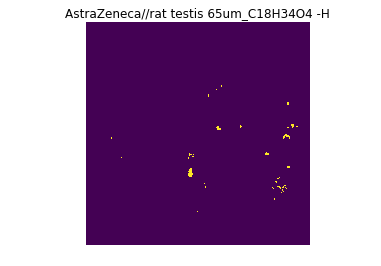

In [8]:
# SET SUMFORMULA NAME, ADDUCT, DATASET for selecting the region
sf_name = 'C18H34O4'
add_name = '-H'
ds_name = 'AstraZeneca//rat testis 65um'

# quantile param
q = 90.
# ion intensity threshold param (-1 = above quantile)
i = 300000

import os
# base dir
base_dir = '/home/katya/Projects/Metabol/'

c_file = os.path.join(base_dir,'corpora/pixel_corpus.mm')

pix_ann_dir = os.path.join(base_dir,'pixel-annotations/45_selected/')

sf_file = os.path.join(pix_ann_dir,'sf_df.msgpack')
dp_file = os.path.join(pix_ann_dir,'ds_pix_cord.msgpack')
dsf_file = os.path.join(pix_ann_dir,'ds_ion_int.msgpack')

import sys  
sys.path.append(base_dir)

import select_region
from select_region import sfname2index

ion_id = sfname2index(sf_file, sf_name, add_name)

from datetime import datetime
from select_region import select_region, viz_region

pixel_ids = select_region(dsf_file, ds_name, ion_id, q, i)
viz_region(dp_file, pixel_ids, ds_name, sf_name+' '+add_name, None)

In [13]:
import gensim
from gensim import corpora
from gensim import models
import numpy

corpus = gensim.corpora.MmCorpus(c_file)

ions2values = {}
for pix_id in pixel_ids:
    for (ion_id,value) in corpus[pix_id]:
        if not ion_id in ions2values: ions2values[ion_id] = []
        ions2values[ion_id].append(value)

region_corpus = []
for ion_id in ions2values:
    region_corpus.append((ion_id, numpy.mean(ions2values[ion_id])))

new_corpus = []
import pandas as pd
dp_iterator = pd.read_msgpack(dp_file, iterator = True)
counter = 0
for name, df in dp_iterator:
    if name == ds_name:
        max_x = df['x'].max()
        max_y = df['y'].max()
        for ir in df.itertuples():
            if ir[0] not in pixel_ids:
                new_corpus.append(corpus[ir[0]])
new_corpus.append(region_corpus)

tfidf_model = gensim.models.TfidfModel(new_corpus)
tfidf_corpus = tfidf_model[new_corpus]

mod_region_corpus = tfidf_corpus[-1]

(12288, 0.0022746213718909734)


In [15]:
# THRESHOLD FOR MOST CHARACTRISTIC IONS
t = 0.00005
# NUMBER OF MOST CHARACTRISTIC IONS
n = 100

import pandas as pd
ion_df = pd.read_msgpack(sf_file)

counter = 0
for (ion_id,value) in mod_region_corpus:
    if counter == n or value<t: break
    counter+=1
    print('%s %s: %f' % (ion_df.at[ion_id,'sf'], ion_df.at[ion_id,'adduct'], value))